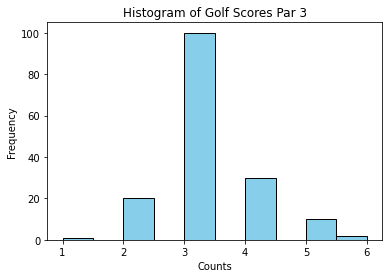

mean  3.208588957055215
std  0.8022513393019645
var  0.6436072114117958


In [1]:
import numpy as np

# Generated this in excel
# change
num_people = [1,20,100,30,10,2]

# Estimated score
est_weight_lost = [
1,2,3,4,5,6
]

# Create an array of data multiplying weight lost by number of people
create_data = np.repeat(est_weight_lost,num_people)


import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(create_data, bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Golf Scores Par 3')

# Display the plot
plt.show()

# calculate standard dev of generated values
# Mean is far greater than Variance so poisson not appropriate
print('mean ',np.mean(create_data))
print('std ',np.std(create_data))
print('var ',np.var(create_data))


# Create statsmodels generalised
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


cd_series = pd.Series(create_data)
# Add constant column to X
X = sm.add_constant(cd_series)


In [2]:
# Get log of mean
# This is the mean in both the gp1 and the gp2 model
np.log(np.mean(create_data))

1.1658312632581607

In [3]:
# GP1 Model

gen_poisson_gp1 = sm.GeneralizedPoisson(cd_series.values, X['const'].values, p=1)

gen_poisson_gp1_results = gen_poisson_gp1.fit()

print(gen_poisson_gp1_results.summary())



Optimization terminated successfully.
         Current function value: 1.266590
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 16
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                  163
Model:             GeneralizedPoisson   Df Residuals:                      162
Method:                           MLE   Df Model:                            0
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:                  0.9146
Time:                        16:07:38   Log-Likelihood:                -206.45
converged:                       True   LL-Null:                       -2418.6
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1658      0.024     49

In [4]:
# GP2 Model - didnt run

gen_poisson_gp2 = sm.GeneralizedPoisson(cd_series.values, X['const'].values, p=2)

gen_poisson_gp2_results = gen_poisson_gp2.fit()

print(gen_poisson_gp2_results.summary())

         Current function value: -44.073889
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                  163
Model:             GeneralizedPoisson   Df Residuals:                      162
Method:                           MLE   Df Model:                            0
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:               0.0003915
Time:                        16:07:45   Log-Likelihood:                 7184.0
converged:                      False   LL-Null:                        7186.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1658        nan        nan        nan         nan         n

C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [19]:
# This formula must be wrong as the lambda is 2.2 - going to change priors
# despite centering priors around 2 - values are still 2.15

import pystan
import numpy as np

# Define the Stan model code
model_code = """
data {
  int<lower=0> N; // Number of observations
  int<lower=0> y[N]; // Count data
} 

parameters {
  real<lower=0> lambda; // Rate parameter
  real<lower=-1, upper=1> alpha; // Dispersion parameter
}

model {
  // Priors
  lambda ~ normal(2, 1); // Prior for lambda, centered around the mean of the data
  alpha ~ normal(0, 0.5); // Prior for alpha

  // Likelihood
  for (n in 1:N) {
    target += log(lambda) + (y[n] - 1) * log(lambda + alpha * y[n]) - (lambda + alpha * y[n]) - lgamma(y[n] + 1);
  } 
}


generated quantities {
 // generate simulated values for each observation
 // How do I change this to sample from a custom distribution rather than Poisson
  vector[N] y_sim;
  for (i in 1:N)
  y_sim[i] = poisson_rng(lambda);
}


"""

# Compile the Stan model
stan_model = pystan.StanModel(model_code=model_code)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64befd00204f74c82e866892a5a7dc33 NOW.


In [5]:
# Generate some synthetic data for demonstration
np.random.seed(123)
N = 100  # Number of observations
y = np.random.poisson(2, N)  # Simulated count data with mean around 2

# print mean of data
print(np.mean(y))

# Get log of mean of poisson - should be same as parameter
print(np.log(np.mean(y)))

# Create data and run through SM model
y_series = pd.Series(y)
# Add constant column to X
X = sm.add_constant(y_series)

# Now run GP1 Model
# Alpha parameter is still -0.1050
gen_poisson_gp1 = sm.GeneralizedPoisson(y_series.values, X['const'].values, p=1)

gen_poisson_gp1_results = gen_poisson_gp1.fit()

print(gen_poisson_gp1_results.summary())

1.93
0.6575200029167941
Optimization terminated successfully.
         Current function value: 1.588086
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                  100
Model:             GeneralizedPoisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:               7.119e-12
Time:                        16:08:06   Log-Likelihood:                -158.81
converged:                       True   LL-Null:                       -158.81
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

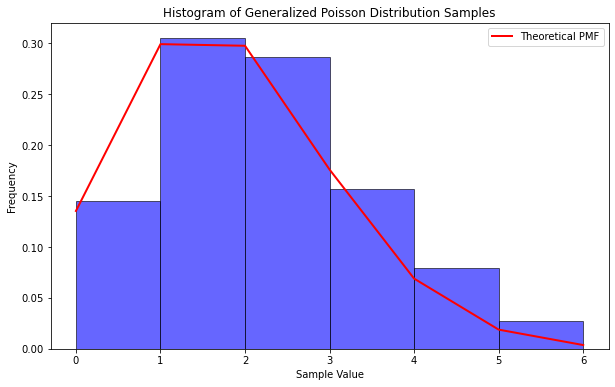

In [6]:
import numpy as np
from scipy.special import factorial
from scipy.optimize import newton

def generalized_poisson_pmf(k, lam, theta):
    """Calculate the PMF of the generalized Poisson distribution."""
    if k < 0:
        return 0
    return lam * (lam + k * theta)**(k-1) * np.exp(-(lam + k * theta)) / factorial(k)

def generalized_poisson_cdf(k, lam, theta):
    """Calculate the CDF of the generalized Poisson distribution."""
    return np.sum([generalized_poisson_pmf(i, lam, theta) for i in range(k+1)])

def generalized_poisson_sample(lam, theta, size=1):
    """Generate random samples from the generalized Poisson distribution."""
    samples = []
    for _ in range(size):
        u = np.random.uniform(0, 1)
        k = 0
        while generalized_poisson_cdf(k, lam, theta) < u:
            k += 1
        samples.append(k)
    return samples if size > 1 else samples[0]

# Example usage
lam = 2.0   # mean
theta = -0.1 # dispersion parameter
samples = generalized_poisson_sample(lam, theta, size=1000)


# Plotting the samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=range(min(samples), max(samples) + 1), density=True, alpha=0.6, color='b', edgecolor='black')
plt.title('Histogram of Generalized Poisson Distribution Samples')
plt.xlabel('Sample Value')
plt.ylabel('Frequency')

# Overlay the theoretical PMF
k_values = np.arange(min(samples), max(samples) + 1)
pmf_values = [generalized_poisson_pmf(k, lam, theta) for k in k_values]
plt.plot(k_values, pmf_values, 'r-', lw=2, label='Theoretical PMF')
plt.legend()

plt.show()


In [7]:
# This model compiled
# This code is the key - look at y sims
# This worked well when setting the priors for the 2 count model
# Now try no priors at all and see how it works
import pystan
import numpy as np

# Define the Stan model code
model_code = """

//Changed log to lpmf due to warning (log pmf)

functions {
  real generalized_poisson_lpmf(int k, real lambda, real alpha) {
    if (k < 0) return negative_infinity();
    return log(lambda) + (k-1) * log(lambda + k * alpha) - (lambda + k * alpha) - lgamma(k + 1);
  }
  
  // Function to calculate the PMF of the generalized Poisson distribution
  // Needed to add vertical bar between first 2 arguments in lpmf
  real generalized_poisson_pmf(int k, real lambda, real alpha) {
    if (k < 0) return 0;
    return exp(generalized_poisson_lpmf(k | lambda, alpha));
  }
  
  
   // Function to calculate the CDF of the generalized Poisson distribution
  real generalized_poisson_cdf(int k, real lambda, real alpha) {
    real cdf = 0;
    for (i in 0:k) {
      cdf += generalized_poisson_pmf(i, lambda, alpha);
    }
    return cdf;
  }
  
  
    // Function to generate a single sample from the generalized Poisson distribution
  int generalized_poisson_rng(real lambda, real alpha) {
    real u = uniform_rng(0, 1);
    int k = 0;
    while (generalized_poisson_cdf(k, lambda, alpha) < u) {
      k += 1;
    }
    return k;
  }
  
}


data {
  int<lower=0> N; // Number of observations
  int<lower=0> y[N]; // Count data
} 

parameters {
  real<lower=0> lambda; // Rate parameter
  real<lower=-1, upper=1> alpha; // Dispersion parameter
}

model {
  // Priors
  // lambda ~ normal(2, 1); // Prior for lambda, centered around the mean of the data
  // alpha ~ normal(0, 0.5); // Prior for alpha

  // Likelihood
  for (n in 1:N) {
    target += generalized_poisson_lpmf(y[n]| lambda, alpha);
  } 
}



generated quantities {
    // generate simulated values for each observation
    vector[N] y_sim; // Replicated data

  // Generate replicated data
  for (i in 1:N) {
     y_sim[i] = generalized_poisson_rng(lambda, alpha);
  }
  
}


"""

# Compile the Stan model
stan_model = pystan.StanModel(model_code=model_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f4475b8c61f1bb8b7e9c4fc63ea775f NOW.


In [8]:
# Use generated data previously to see if mean alligns

# Prepare data for Stan
model_data = {'N': N, 'y': y}

print(np.mean(y))
print(np.std(y))


# Fit the model
# Mean is still 2.2 here 
# but y sim is 1.96
fit = stan_model.sampling(data=model_data, iter=2000, chains=4)

# Print fit summary
print(fit)


1.93
1.2268251709188234
Inference for Stan model: anon_model_3f4475b8c61f1bb8b7e9c4fc63ea775f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda       2.16  5.5e-3    0.2   1.79   2.02   2.16   2.29   2.57   1347    1.0
alpha       -0.11  1.9e-3   0.07  -0.24  -0.16  -0.11  -0.07   0.02   1299    1.0
y_sim[1]     1.98    0.02   1.29    0.0    1.0    2.0    3.0    5.0   4008    1.0
y_sim[2]     1.92    0.02   1.28    0.0    1.0    2.0    3.0    5.0   4080    1.0
y_sim[3]     1.93    0.02   1.24    0.0    1.0    2.0    3.0    5.0   3943    1.0
y_sim[4]     1.93    0.02   1.27    0.0    1.0    2.0    3.0    5.0   3957    1.0
y_sim[5]     1.94    0.02   1.25    0.0    1.0    2.0    3.0    5.0   3913    1.0
y_sim[6]     1.94    0.02   1.24    0.0    1.0    2.0    3.0    5.0   4025    1.0
y_sim[7]     1.94    0.02   1.27    0.0    1.0   

In [9]:
# Put Posterior draws into a dictionary
trace = fit.extract()


# Put simulations into an array
y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
# statistics are almos the same as statsmodel model
trace_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
lambda,2.160315,0.005489,0.201465,1.791386,2.017205,2.159048,2.291781,2.568949,1347.376891,1.003787
alpha,-0.110707,0.001857,0.066908,-0.236652,-0.157747,-0.111785,-0.066651,0.020575,1298.792095,1.002982
y_sim[1],1.977250,0.020340,1.287691,0.000000,1.000000,2.000000,3.000000,5.000000,4008.135494,1.000439
y_sim[2],1.919000,0.020045,1.280371,0.000000,1.000000,2.000000,3.000000,5.000000,4079.974402,0.999452
y_sim[3],1.932000,0.019718,1.238248,0.000000,1.000000,2.000000,3.000000,5.000000,3943.487954,0.999499
...,...,...,...,...,...,...,...,...,...,...
y_sim[97],1.912250,0.020191,1.270021,0.000000,1.000000,2.000000,3.000000,5.000000,3956.367457,0.999369
y_sim[98],1.937000,0.020223,1.251768,0.000000,1.000000,2.000000,3.000000,4.000000,3831.349652,1.001086
y_sim[99],1.937500,0.020181,1.275343,0.000000,1.000000,2.000000,3.000000,5.000000,3993.693389,1.000975
y_sim[100],1.979250,0.021430,1.291602,0.000000,1.000000,2.000000,3.000000,5.000000,3632.443676,1.000296


In [1]:
# This time will be using discree count data

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object - Change this to round total
ts_data = pd.Series(power['Round_total'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]


C:\Users\killi\AppData\Local\Temp/ipykernel_16336/3665337522.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_16336/3665337522.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_16336/3665337522.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [2]:
# Try set priors for golf model 
import pystan
import numpy as np

# Define the Stan model code
model_code = """

//Changed log to lpmf due to warning (log pmf)

functions {
  real generalized_poisson_lpmf(int k, real lambda, real alpha) {
    if (k < 0) return negative_infinity();
    return log(lambda) + (k-1) * log(lambda + k * alpha) - (lambda + k * alpha) - lgamma(k + 1);
  }
  
  // Function to calculate the PMF of the generalized Poisson distribution
  // Needed to add vertical bar between first 2 arguments in lpmf
  real generalized_poisson_pmf(int k, real lambda, real alpha) {
    if (k < 0) return 0;
    return exp(generalized_poisson_lpmf(k | lambda, alpha));
  }
  
  
   // Function to calculate the CDF of the generalized Poisson distribution
  real generalized_poisson_cdf(int k, real lambda, real alpha) {
    real cdf = 0;
    for (i in 0:k) {
      cdf += generalized_poisson_pmf(i, lambda, alpha);
    }
    return cdf;
  }
  
  
    // Function to generate a single sample from the generalized Poisson distribution
  int generalized_poisson_rng(real lambda, real alpha) {
    real u = uniform_rng(0, 1);
    int k = 0;
    while (generalized_poisson_cdf(k, lambda, alpha) < u) {
      k += 1;
    }
    return k;
  }
  
}


data {
  int<lower=0> N; // Number of observations
  int<lower=0> y[N]; // Count data
} 

parameters {
  real<lower=0> lambda; // Rate parameter
  real<lower=-1, upper=1> alpha; // Dispersion parameter
}

model {
  // Priors
   lambda ~ normal(72, 1); // Prior for lambda, centered around the mean of the data
   alpha ~ normal(0, 0.5); // Prior for alpha

  // Likelihood
  for (n in 1:N) {
    target += generalized_poisson_lpmf(y[n]| lambda, alpha);
  } 
}



generated quantities {
    // generate simulated values for each observation
    vector[N] y_sim; // Replicated data

  // Generate replicated data
  for (i in 1:N) {
     y_sim[i] = generalized_poisson_rng(lambda, alpha);
  }
  
}


"""

# Compile the Stan model
stan_model = pystan.StanModel(model_code=model_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f29665185209435a839efea3b031093 NOW.


In [ ]:
# Use my golf data
# This seemed to run - but the sums are way off
# The man is 65 - this may be to do with the priors I set
# When I don't set priors it takes quite a while to even get to 20 iterations
# set priors at 72,1 and centred around 0 for alpha
# still taking a while - maybe need wider priors?
N = len(train_series.values)  # Number of observations
y = train_series.values # Actual data

# Get mean and sd of data
print(np.mean(y))
print(np.std(y))

# Prepare data for Stan
model_data = {'N': N, 'y': y}

# Fit the model
fit = stan_model.sampling(data=model_data, iter=20, chains=4)

# Print fit summary
# The mean seems to be way off - but maybe it generates good data
print(fit)


71.2125
3.2353274563790295


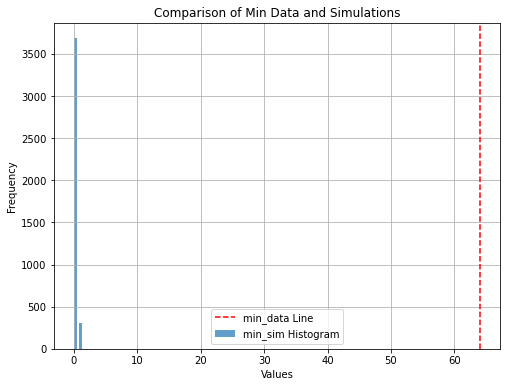

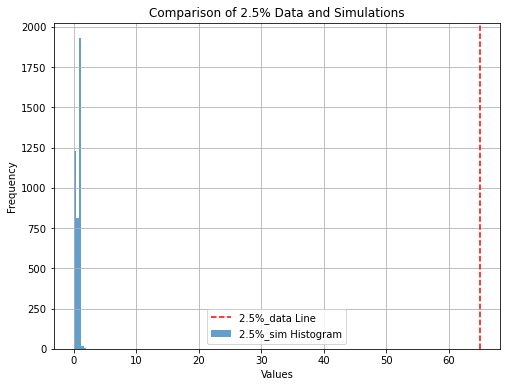

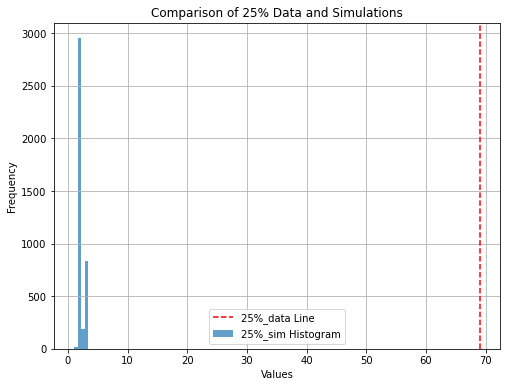

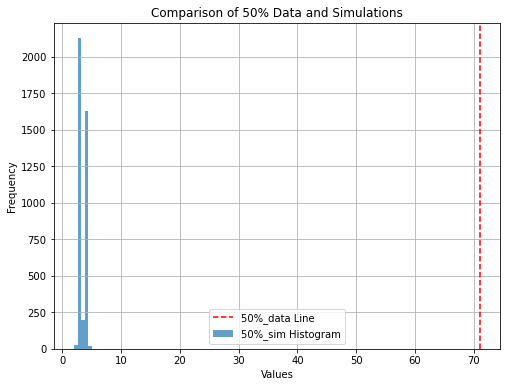

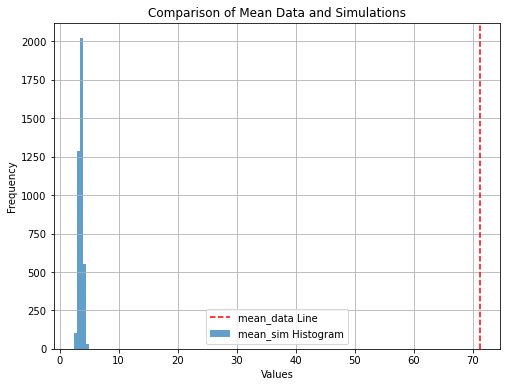

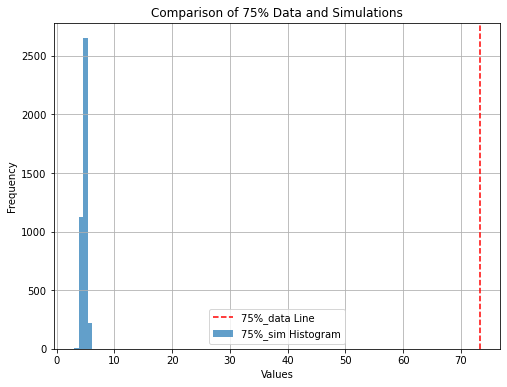

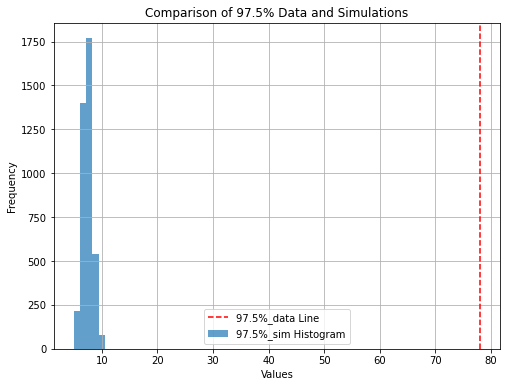

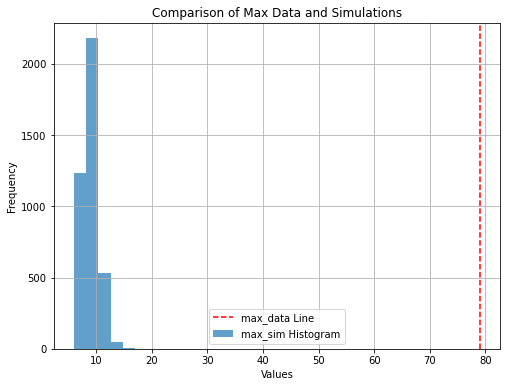

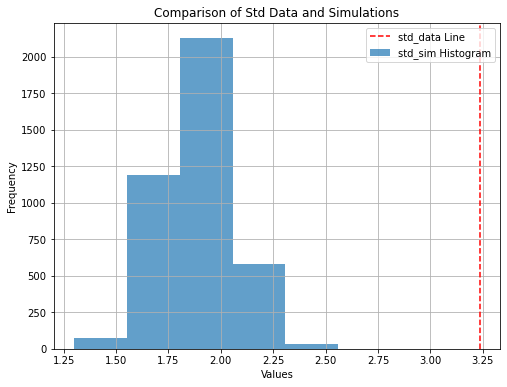

In [33]:
# Normal distribution
# Fits the data the best so far - even though too much data in the tails

import numpy as np


# Define statistics to loop through
# Will have 1k values for each value 
# Taking the min of 100 obs
statistics = {
    'min': (np.min(y), np.min(y_sim, axis=1)),
    '2.5%': (np.percentile(y,2.5),np.percentile(y_sim,2.5,axis=1)),
    '25%': (np.percentile(y,25),np.percentile(y_sim,25,axis=1)),
    '50%': (np.percentile(y,50),np.percentile(y_sim,50,axis=1)),
    'mean': (np.mean(y), np.mean(y_sim, axis=1)),
    '75%': (np.percentile(y,75),np.percentile(y_sim,75,axis=1)),
    '97.5%': (np.percentile(y,97.5),np.percentile(y_sim,97.5,axis=1)),
    'max': (np.max(y), np.max(y_sim, axis=1)),
    'std': (np.std(y), np.std(y_sim, axis=1))
}

# Plotting loop
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=5, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()

